In [1]:
import pandas as pd
import quandl,math, datetime
import numpy as np
from sklearn import preprocessing,svm
from sklearn.model_selection import cross_validate, train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import mean_squared_error
style.use('ggplot')

In [2]:
#Frankfurt stock exchange
data=pd.read_csv('C:/Users/Srujan/Documents/Datasets/frankfurt_stock_exchange.csv',parse_dates=['Date'],index_col='Date')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3129 entries, 2008-05-09 to 2020-08-18
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   2659 non-null   float64
 1   High                   2992 non-null   float64
 2   Low                    2992 non-null   float64
 3   Close                  3129 non-null   float64
 4   Change                 10 non-null     float64
 5   Traded Volume          2958 non-null   float64
 6   Turnover               2946 non-null   float64
 7   Last Price of the Day  0 non-null      float64
 8   Daily Traded Units     0 non-null      float64
 9   Daily Turnover         12 non-null     float64
dtypes: float64(10)
memory usage: 268.9 KB
None


,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2008-05-09,25.90,29.68,25.90,29.40,NaN,26986.0,791604.0,NaN,NaN,NaN
2008-05-12,29.45,29.45,29.00,29.45,NaN,981.0,28612.0,NaN,NaN,NaN
2008-05-13,29.50,29.90,29.44,29.85,NaN,1638.0,48289.0,NaN,NaN,NaN
2008-05-14,29.30,29.30,28.77,29.30,NaN,183.0,5344.0,NaN,NaN,NaN
2008-05-15,29.35,29.70,28.75,29.70,NaN,674.0,19824.0,NaN,NaN,NaN


In [3]:
data.drop(columns=['Change','Last Price of the Day','Daily Traded Units','Daily Turnover','Turnover'],inplace=True)
data.head(20)

,Open,High,Low,Close,Traded Volume
Date,,,,,
2008-05-09,25.90,29.68,25.90,29.40,26986.0
2008-05-12,29.45,29.45,29.00,29.45,981.0
2008-05-13,29.50,29.90,29.44,29.85,1638.0
2008-05-14,29.30,29.30,28.77,29.30,183.0
2008-05-15,29.35,29.70,28.75,29.70,674.0
2008-05-16,29.70,29.70,28.63,29.60,368.0
2008-05-19,29.59,31.30,29.59,31.10,5050.0
2008-05-20,29.94,30.00,29.15,29.40,7633.0
2008-05-21,30.00,31.50,30.00,31.50,11880.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3129 entries, 2008-05-09 to 2020-08-18
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2659 non-null   float64
 1   High           2992 non-null   float64
 2   Low            2992 non-null   float64
 3   Close          3129 non-null   float64
 4   Traded Volume  2958 non-null   float64
dtypes: float64(5)
memory usage: 146.7 KB


In [5]:
for feat in data.columns:
    data[feat].fillna(data[feat].rolling(4,min_periods=1).mean())
    
data['HL_PCT']=(data['High']-data['Close'])/data['Close']*100
data['PCT_change']=(data['Close']-data['Open'])/data['Open']*100
data.head(10)

,Open,High,Low,Close,Traded Volume,HL_PCT,PCT_change
Date,,,,,,,
2008-05-09,25.90,29.68,25.90,29.40,26986.0,0.952381,13.513514
2008-05-12,29.45,29.45,29.00,29.45,981.0,0.000000,0.000000
2008-05-13,29.50,29.90,29.44,29.85,1638.0,0.167504,1.186441
2008-05-14,29.30,29.30,28.77,29.30,183.0,0.000000,0.000000
2008-05-15,29.35,29.70,28.75,29.70,674.0,0.000000,1.192504
2008-05-16,29.70,29.70,28.63,29.60,368.0,0.337838,-0.336700
2008-05-19,29.59,31.30,29.59,31.10,5050.0,0.643087,5.103075
2008-05-20,29.94,30.00,29.15,29.40,7633.0,2.040816,-1.803607
2008-05-21,30.00,31.50,30.00,31.50,11880.0,0.000000,5.000000


In [6]:
data=data[['Close','HL_PCT','PCT_change']]
forecast_out=4
data['forecast_col'] = data['Close'].shift(-forecast_out)
data.dropna(inplace=True)
data

,Close,HL_PCT,PCT_change,forecast_col
Date,,,,
2008-05-09,29.40,0.952381,13.513514,29.7
2008-05-12,29.45,0.000000,0.000000,29.6
2008-05-13,29.85,0.167504,1.186441,31.1
2008-05-14,29.30,0.000000,0.000000,29.4
2008-05-15,29.70,0.000000,1.192504,31.5
...,...,...,...,...
2020-08-06,148.00,1.216216,0.543478,146.0
2020-08-07,151.00,0.662252,1.615074,147.6
2020-08-10,146.00,4.520548,-4.325033,145.6


In [7]:
train_count =int(data.shape[0]*0.85)
test_count = data.shape[0]-train_count

In [8]:
y_train = data.iloc[:train_count,3]
y_test  = data.iloc[train_count:,3]
print(y_train.shape,y_test.shape)

(2256,) (399,)


In [9]:
x_train = data.iloc[:train_count,0:-1]
x_test = data.iloc[train_count:,0:-1]

In [10]:
x_train

,Close,HL_PCT,PCT_change
Date,,,
2008-05-09,29.40,0.952381,13.513514
2008-05-12,29.45,0.000000,0.000000
2008-05-13,29.85,0.167504,1.186441
2008-05-14,29.30,0.000000,0.000000
2008-05-15,29.70,0.000000,1.192504
...,...,...,...
2017-09-12,157.60,0.158629,1.808786
2017-09-13,160.10,0.000000,1.618534
2017-09-14,160.45,0.529760,0.218613


In [11]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators':np.arange(50,250,50),
        'max_depth':np.arange(5,30,5),
         'min_samples_leaf':[3,4,5,6],
         'min_samples_split':[6,7,8,9,10]}
ran = RandomForestRegressor()
ran_grid = RandomizedSearchCV(ran,params,scoring='neg_mean_squared_error',cv=5,n_iter=25)
tuned=ran_grid.fit(x_train,y_train)

In [15]:
print(tuned.best_params_)

{'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_depth': 10}


In [16]:
clf = RandomForestRegressor(n_estimators= 50,min_samples_split=7,min_samples_leaf=6,max_depth= 10)
clf.fit(x_train,y_train)
accuracy=clf.score(x_test,y_test)
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)
print(accuracy)
print(mean_squared_error(y_train,y_pred_train))
print(mean_squared_error(y_test,y_pred_test))

0.9075843582623413
12.011329553572027
50.69457471302416


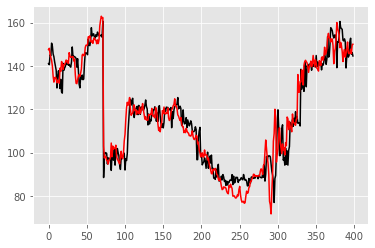

In [17]:
plt.plot(y_pred_test,color='black')
plt.plot(y_test,color='red')
plt.show()

In [18]:
import pickle
filename = 'C:/Users/Srujan/Documents/Git/Frankfurt/frankfurt_model.pkl'
pickle.dump(clf,open(filename,'wb'))